## Tumor Segmentation with U-Net Networks

### Imports

In [1]:
# Imports ----------------------------------------------------------------------

# Common Python imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm

# Torch imports
import torch as th
from torch.utils.data import DataLoader
from safetensors.torch import load_model, load_file

# Typining hints
from typing import List, Union, Callable, Tuple

# Change cwd to the parent directory and add it to the Python path
os.chdir("/home/marco/deep-learning-project/")
sys.path.append(os.getcwd())
print(f"Current working directory: {os.getcwd()}")

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.3,
	},
)

# Model import
from models.classic_unet import ClassicUNet
# from models.improved_unet import ImprovedUNet
# from models.attention_unet import AttentionUNet

# Dataset loader
from utils.datasets import load_segmentation

# Utils imports
from utils.analysis import *
from utils.metrics import *


# Datasets directories (relative to the project root) --------------------------
DATASETS: str = "datasets"
SEGMENTATION: str = os.path.join(DATASETS, "segmentation/data")
SAVE_PATH: str = "models/saved_models"
SAVE_LOSS_PATH: str = "models/saved_losses"


# Hyperparameters --------------------------------------------------------------
DEVICE_AUTODETECT: bool = True
PERCENTAGE: float = 0.5
SPLIT: int = 0.7
IMG_SIZE: int = 128
N_FILTERS: int = 16
BATCH_TRAIN: int = 64
BATCH_VALID: int = 64
EPOCHS: int = 10
CRITERION: Union[th.nn.Module, Callable[[th.Tensor, th.Tensor], th.Tensor]] = (
    th.nn.BCEWithLogitsLoss()
)
LR: float = 1e-3
WEIGHT_DECAY: float = 1e-2


# Device setup -----------------------------------------------------------------
device: th.device = th.device(
    "cuda" if th.cuda.is_available() and DEVICE_AUTODETECT else "cpu"
)
print(f"Using device: {device}")
if th.cuda.device_count() > 1: print(f"Using {th.cuda.device_count()} GPUs")

Current working directory: /home/marco/deep-learning-project
Using device: cpu


### Dataset

In [2]:
# Load the BraTS2020 dataset ---------------------------------------------------

# Load the dataset
train_dataloader, valid_dataloader = load_segmentation(
    directory = SEGMENTATION,
    split = SPLIT,
    train_batch_size = BATCH_TRAIN,
    valid_batch_size = BATCH_VALID,
    percentage = PERCENTAGE,
    resize = (IMG_SIZE, IMG_SIZE),
    deterministic = True
)

# Count examples in the dataset
print(f"Total examples:      {len(train_dataloader.dataset) + len(valid_dataloader.dataset)} examples")
print(f"Train-Test split:    {SPLIT*100:.0f}% - {(1-SPLIT)*100:.0f}%") 
print(f"Train-Test examples: {len(train_dataloader.dataset)} - {len(valid_dataloader.dataset)}")

Total examples:      28597 examples
Train-Test split:    70% - 30%
Train-Test examples: 20017 - 8580


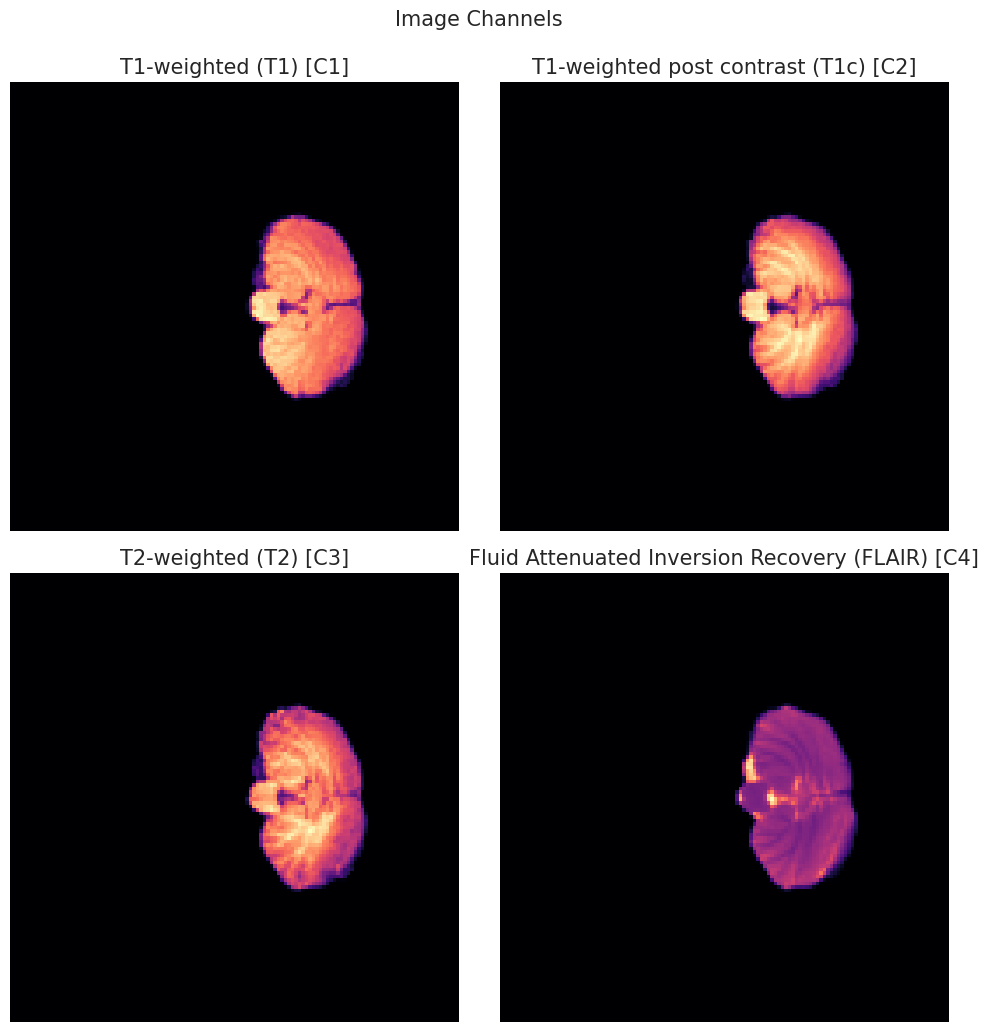

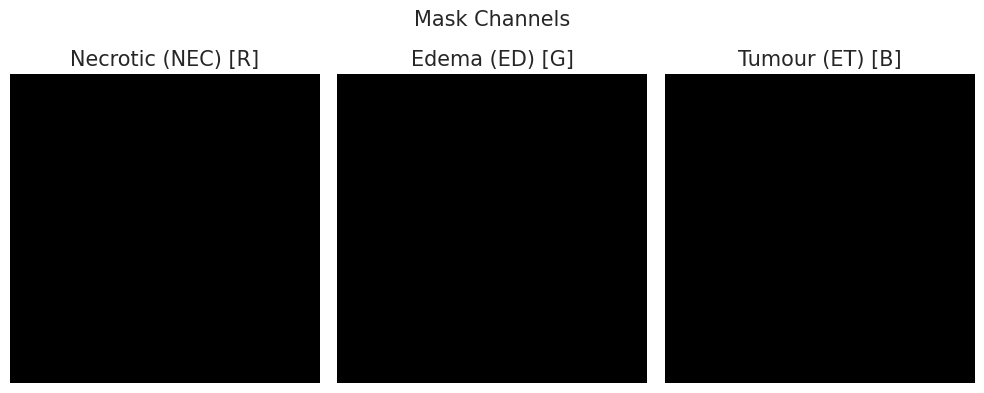

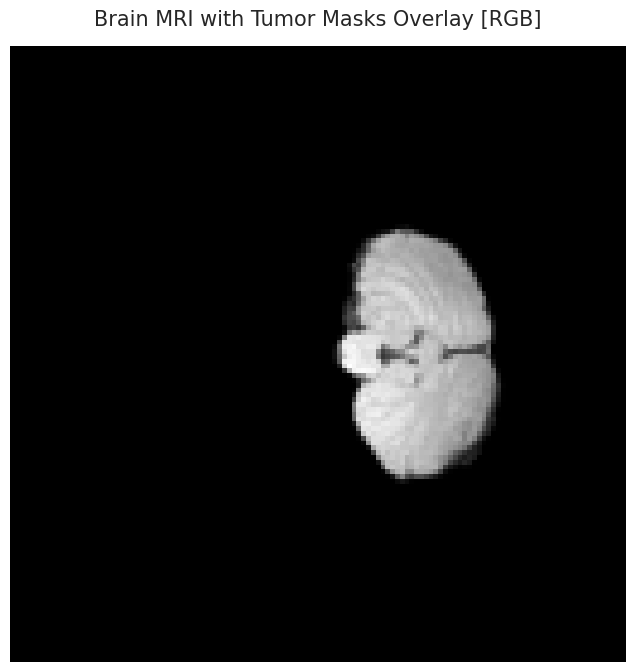

In [3]:
# Sample a datapoint from the training dataset
image, mask = next(iter(train_dataloader))

# Choose a random index (between 0 - BATCH_TRAIN) to display that image
index:int = np.random.randint(0, BATCH_TRAIN)

# View images using plotting functions
display_image_channels(image[index])
display_mask_channels(mask[index])
display_overlay(image[index], mask[index])

### Classic U-Net Model

Define and load the trained model

In [4]:
# Select and initialize the U-Net model
model: th.nn.Module = ClassicUNet(n_filters=N_FILTERS)
# model: th.nn.Module = ImprovedUNet(n_filters=N_FILTERS)
# model: th.nn.Module = AttentionUNet(n_filters=N_FILTERS)

# Move the model to the device (or devices)
if th.cuda.device_count() > 1:
    print(f"Using {th.cuda.device_count()} GPUs")
    model = th.nn.DataParallel(model)
model.to(device)

# Count the total number of parameters
total_params = count_parameters(model)
print(f'Total Parameters: {total_params:,}')

# Load the model from the saved checkpoint
saved_epoch: int = 10
saved_name: str = f"{model.module.name if isinstance(model, th.nn.DataParallel) else model.name}_e{saved_epoch}.pth"
load_name: str = os.path.join(SAVE_PATH, saved_name)

# Load the state dictionary of trained parameters using safetensors
state_dict = load_file(load_name)

# Remove 'module.' prefix if it exists
# (this is necessary when using DataParallel wrapper in training
# and loading the model on a single device later)
state_dict = remove_module_prefix(state_dict)

# Load the trained parameters
model.load_state_dict(state_dict)

Total Parameters: 1,375,043


<All keys matched successfully>

View model predictions

Performance metrics (%)
------------------------------------------------------
         Dice  Accuracy  FPR  FNR  Precision  Recall
Red      0.00    100.00 0.00 0.00       0.00    0.00
Green    0.00    100.00 0.00 0.00       0.00    0.00
Blue     0.00    100.00 0.00 0.00       0.00    0.00
Average  0.00    100.00 0.00 0.00       0.00    0.00


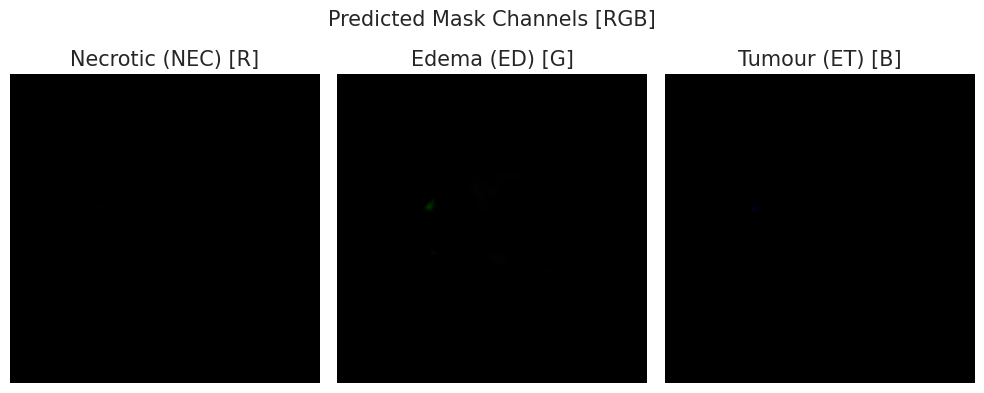

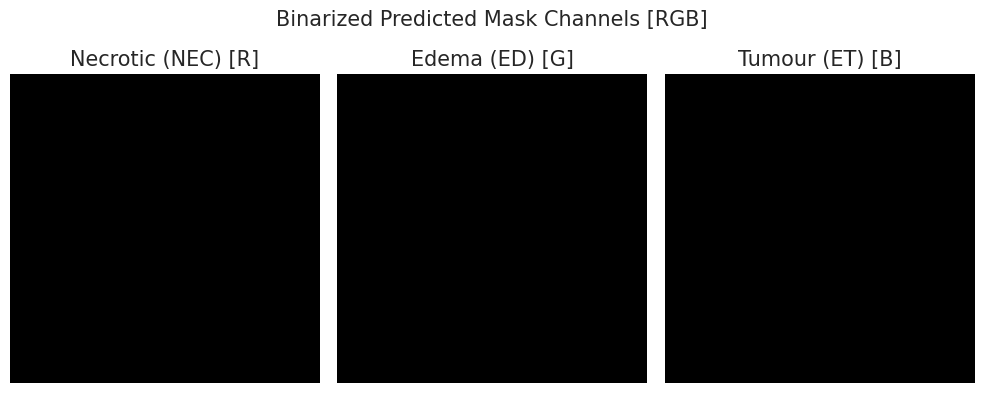

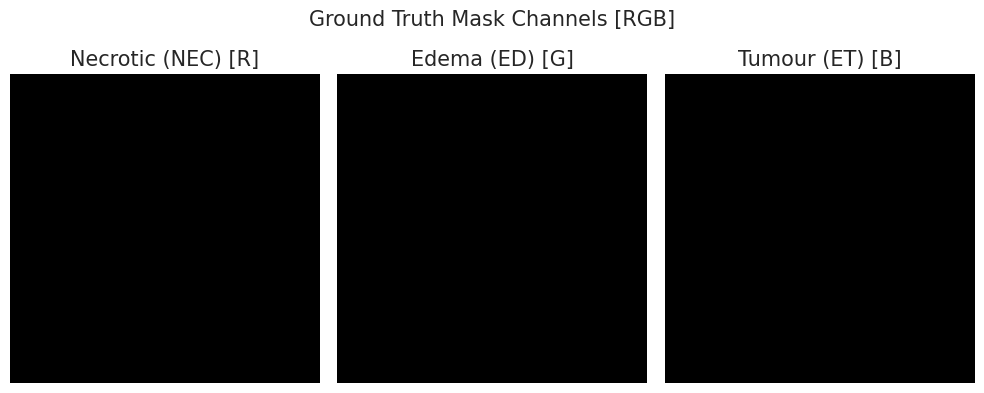

In [38]:
# Get an image from the validation dataset that the model hasn't been trained on


test_image, test_mask = next(iter(valid_dataloader))
index: int = np.random.randint(0, BATCH_VALID)

# Add batch dimension to the test image
test_image = test_image[index].unsqueeze(0)
test_mask = test_mask[index].unsqueeze(0)

# Compute metrics
prediction = model(test_image.to(device))
mask = test_mask.to(device)
dice_coeff = dice(prediction, mask)
accuracy = accuracy2D(prediction, mask)
fpr = fpr2D(prediction, mask)
fnr = fnr2D(prediction, mask)
precision = precision2D(prediction, mask)
recall = recall2D(prediction, mask)

# Convert metrics to percentage format
dice_coeff = [score * 100 for score in dice_coeff]
accuracy = [score * 100 for score in accuracy]
fpr = [score * 100 for score in fpr]
fnr = [score * 100 for score in fnr]
precision = [score * 100 for score in precision]
recall = [score * 100 for score in recall]

# Create a DataFrame to display the metrics
metrics = {
    'Dice': dice_coeff,
    'Accuracy': accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'Precision': precision,
    'Recall': recall,
}
rows = ['Red', 'Green', 'Blue', 'Average']
df = pd.DataFrame(metrics, index=rows)
pd.options.display.float_format = '{:.2f}'.format

print("Performance metrics (%)")
print("------------------------------------------------------")
print(df)

# Display the prediction
display_prediction(model, test_image, test_mask, device=device)